Advanced Lane Lines
==

# The flow of pipeline
1. Undistort the image with camera calibration
1. Make binary image by threshold for color conversion and gradients
1. Warp the image to birds eye view

### Undistort the image with camera calibration

In [1]:
import cv2
import pickle
with open('calib_cam_dist_pickle.p', 'rb') as f:
    cam_calib = pickle.load(f)

def undistort(src, calib):
    return cv2.undistort(src, calib['mtx'], calib['dist'], None, calib['mtx'])

### Make thresholded binary image for lane lines

In [17]:
import numpy as np

def binarize_for_line(src, params):
    
    def sobel_thresh(gray, params):
        
        def mag_thresh(sobelx, sobely, thr_min, thr_max):
            # Calculate the gradient magnitude
            gradmag = np.sqrt(sobelx**2 + sobely**2)
            # Rescale to 8 bit
            scale_factor = np.max(gradmag)/255 
            gradmag = (gradmag/scale_factor).astype(np.uint8) 
            # Create a binary image of ones where threshold is met, zeros otherwise
            binary_mag = np.zeros_like(gradmag)
            binary_mag[(gradmag >= thr_min) & (gradmag <= thr_max)] = 1
            return binary_mag
        
        def dir_thresh(sobelx, sobely, thr_min, thr_max):
            # Take the absolute value of the gradient direction, 
            # apply a threshold, and create a binary image result
            absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
            binary_dir =  np.zeros_like(absgraddir)
            binary_dir[(absgraddir >= thr_min) & (absgraddir <= thr_max)] = 1
            return binary_dir
        
        gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        ksize = params['ksize']
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize)
        mag_binary = mag_thresh(sobelx, sobely, *params['mag_thr'])
        dir_binary = dir_thresh(sobelx, sobely, *params['dir_thr'])
        mag_and_dir = np.zeros_like(mag_binary)
        mag_and_dir[(mag_binary == 1) & (dir_binary == 1)] = 1
        return mag_and_dir
    
    def color_thresh(src, thr_min, thr_max):
        hls = cv2.cvtColor(src, cv2.COLOR_RGB2HLS)
        s_channel = hls[:,:,2]
        s_binary = np.zeros_like(s_channel)
        s_binary[(s_channel >= thr_min) & (s_channel <= thr_max)] = 1
        return s_binary
    
    # Combine the two binary thresholds
    grad_binary = sobel_thresh(src, params['sobel'])
    color_binary = color_thresh(src, *params['color_thr'])
    combined_binary = np.zeros_like(grad_binary)
    combined_binary[(grad_binary == 1) & (color_binary == 1)] = 1
    return combined_binary
    
    
    

## Test Bench

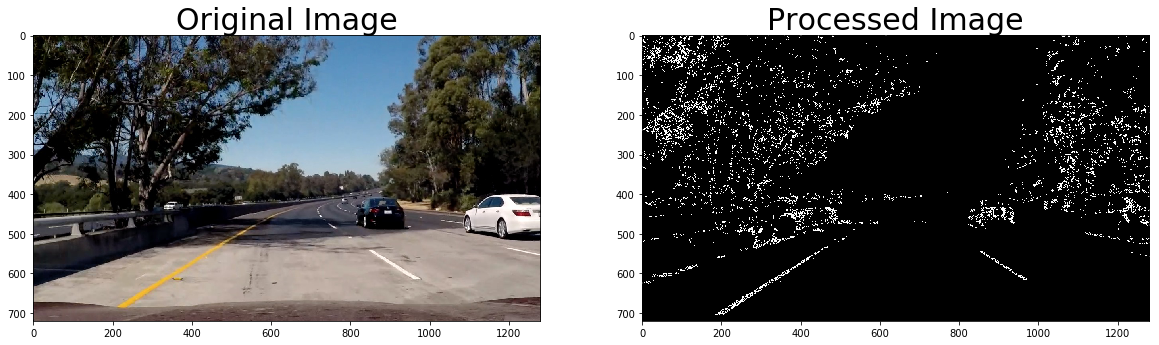

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt

src = cv2.imread('test_images/test5.jpg')
dst = undistort(src, cam_calib)

BINARIZE_PARAMS = {
    'sobel': {
        'ksize': 5,
        'mag_thr': (0, 100),
        'dir_thr': (0.3, 1.3)
    },
    'color_thr': (170, 255),
}

dst = binarize_for_line(dst, BINARIZE_PARAMS)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(cv2.cvtColor(src, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=30)
# ax2.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
ax2.imshow(dst, cmap='gray')
ax2.set_title('Processed Image', fontsize=30)